## Project file system setup

In [ ]:
# Install SciPy (for basic stats) and statsmodels (for McNemar’s test)
!pip install -q scipy statsmodels
# Setup project paths and GPU environment
from google.colab import drive
import os

drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/DL4H-Project"
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# !ls -l $MODELS_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 🧮 Phase 6.1: General Evaluation Framework
We define a unified evaluation pipeline covering:

- Task‐specific metric calculations  
- Standardized reporting (tabular & CSV)  
- Statistical significance testing (e.g., McNemar’s test)  
- Visualization utilities for metrics and confusion matrices

In [ ]:
import os, json, glob
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy.core.multiarray as ma  # to grab the 'scalar' class
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# ── 1) Load all finetuned result JSONs into DataFrames ─────────────────────────────────────
def load_finetuned_results(task: str, base_dir: str = RESULTS_DIR) -> pd.DataFrame:
    """
    Load all experiment JSONs for a given task into a single DataFrame.
    Expects each JSON to contain at least:
      {
        "model": "<model_name>",
        "data_fraction": <int>,
        "status": "<completed|failed|...>",    # optional
        "metrics": { ... }
      }
    """
    pattern = os.path.join(base_dir, task, "*.json")
    records = []
    for path in glob.glob(pattern):
        with open(path, "r") as f:
            data = json.load(f)

        model    = data.get("model")
        frac     = data.get("data_fraction")
        status   = data.get("status", None)
        metrics  = data.get("metrics", {})
        if model.lower() == "t5-base":
          model = "t5-base"

        if model.lower() == "emilyalsentzer/bio_clinicalbert":
          model = "BioClinRoBERTa"

        # flatten
        rec = {
            "task":      task,
            "model":     model,
            "data_fraction":  frac,
            "status":    status,
            "source": "finetuned"
        }
        rec.update(metrics)
        records.append(rec)

    return pd.DataFrame(records)

# ── 2) Load all ICL result JSONs into DataFrames ─────────────────────────────────────
def load_icl_results(file_path: str, task: str) -> pd.DataFrame:
    with open(file_path, "r") as f:
        raw_data = json.load(f)

    records = []
    for model_name, df_map in raw_data.items():
        for data_frac, shot_list in df_map.items():
            for run in shot_list:
              # This is the updated line
                model = run["model"]
                if model.lower() == "t5-base":
                    model = "t5-base"

                entry = {
                    "model": model,
                    "task": task,
                    "data_fraction": int(run["data_fraction"]),
                    "num_shots": run["num_shots"],
                    "source": "icl"
                }
                if task == "mednli":
                    entry["accuracy"] = run["accuracy"]
                    # entry["f1"] = run["f1"]
                elif task == "radqa":
                    entry["f1"] = run["f1"]
                    entry["exact_match"] = run["exact_match"]
                elif task == "clip":
                    entry["micro_f1"] = run["micro_f1"]
                    entry["macro_f1"] = run["macro_f1"]
                records.append(entry)
    return pd.DataFrame(records)

df_icl_mednli = load_icl_results(RESULTS_DIR + "/icl/mednli_results/icl_complete_results.json", "mednli")
df_icl_radqa  = load_icl_results(RESULTS_DIR + "/icl/radqa_results/radqa_icl_complete_results.json", "radqa")
df_icl_clip   = load_icl_results(RESULTS_DIR + "/icl/clip_results/clip_icl_complete_results.json", "clip")

df_finetuned_mednli = load_finetuned_results("mednli")

df_finetuned_radqa = load_finetuned_results("radqa")
df_finetuned_clip = load_finetuned_results("clip")

df_all = pd.concat([
    df_finetuned_mednli,
    df_icl_mednli,
    df_finetuned_radqa,
    df_icl_radqa,
    df_finetuned_clip,
    df_icl_clip
], ignore_index=True)

df_finetuned_mednli.head()
# df_icl_radqa.head()

,task,model,data_fraction,status,source,test_loss,accuracy,precision,recall,f1
0,mednli,t5-base,1,None,finetuned,0.592939,0.426864,0.458126,0.426864,0.382340
1,mednli,t5-base,5,None,finetuned,0.392735,0.481716,0.473453,0.481716,0.475509
2,mednli,t5-base,10,None,finetuned,0.287589,0.603376,0.593074,0.603376,0.595174
3,mednli,t5-base,25,None,finetuned,0.213997,0.715190,0.712374,0.715190,0.713148
4,mednli,t5-base,100,None,finetuned,0.185373,0.779887,0.779106,0.779887,0.778364


## 6.2 MedNLI Evaluation

📋 Finetuned MedNLI Accuracy Table:


data_fraction,1,5,10,25,100
model,,,,,
BioClinRoBERTa,0.326,0.365,0.485,0.654,0.793
roberta-large,0.333,0.333,0.506,0.789,0.838
t5-base,0.427,0.482,0.603,0.715,0.780
t5-large,0.413,0.413,0.414,0.414,0.414


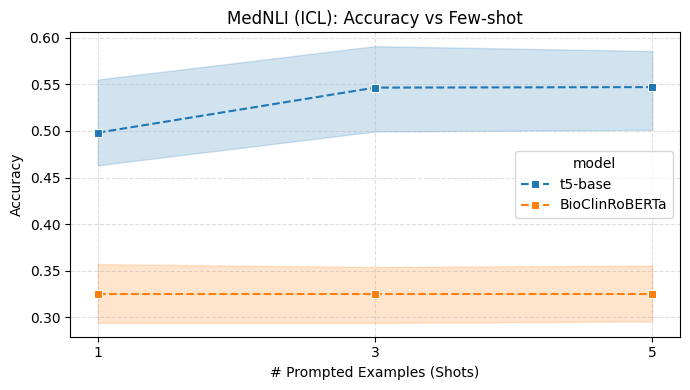

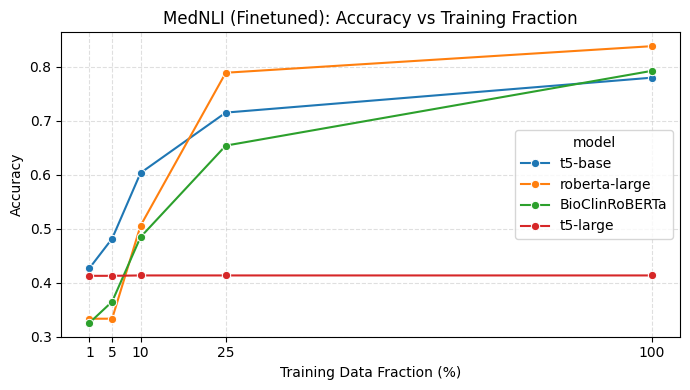

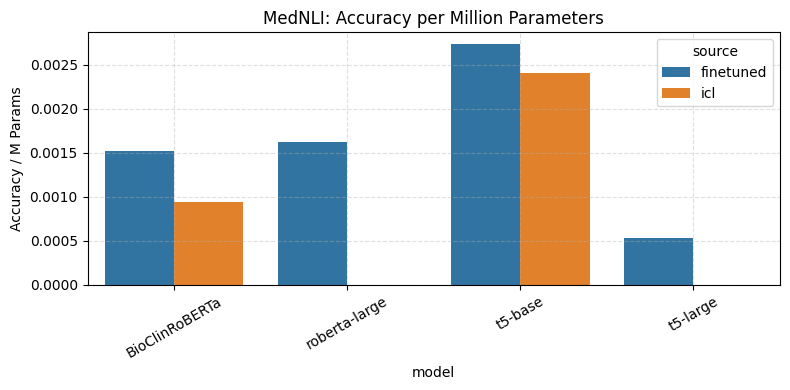

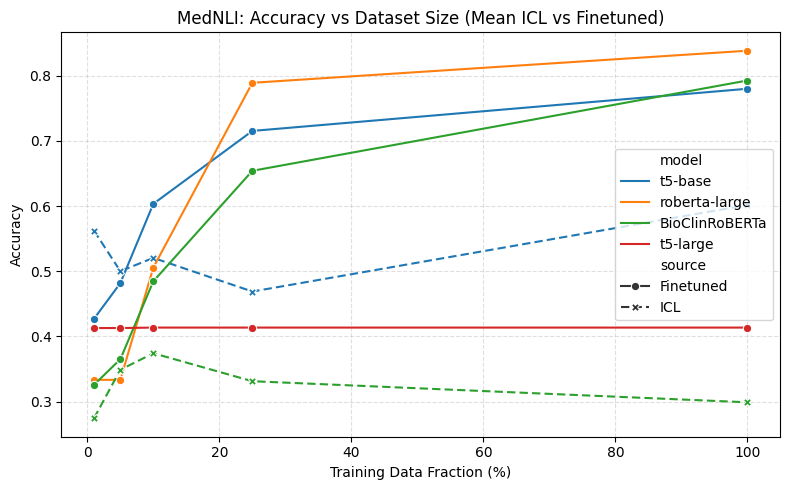

📋 Finetuned Efficiency (acc_per_M) Table:


data_fraction,1,5,10,25,100
model,,,,,
BioClinRoBERTa,0.001,0.001,0.001,0.002,0.002
roberta-large,0.001,0.001,0.001,0.002,0.002
t5-base,0.002,0.002,0.003,0.003,0.004
t5-large,0.001,0.001,0.001,0.001,0.001


In [ ]:
# MedNLI Evaluation

import seaborn as sns
import matplotlib.pyplot as plt

# ── 1. Define parameter counts (M) for all models ───────────────────────────
param_counts = {
    "t5-base": 220,
    "t5-large": 770,
    "roberta-large": 345,
    "clinical-t5-base": 220,
    "clinical-t5-large": 770,
    "emilyalsentzer/Bio_ClinicalBERT": 345,
    "BioClinRoBERTa": 345,
    "google/flan-t5-xl": 1100,
    "google/flan-t5-xxl": 11000,
    "gpt-3": 175000
}

# ── 2. Compute efficiency for finetuned ─────────────────────────────────────
df_finetuned_mednli["params_M"] = df_finetuned_mednli["model"].map(param_counts)
df_finetuned_mednli["acc_per_M"] = df_finetuned_mednli["accuracy"] / df_finetuned_mednli["params_M"]

# ── 3. Compute efficiency for ICL ───────────────────────────────────────────
df_icl_mednli["params_M"] = df_icl_mednli["model"].map(param_counts)
df_icl_mednli["acc_per_M"] = df_icl_mednli["accuracy"] / df_icl_mednli["params_M"]

# ── 4. Accuracy Table (Pivot) ───────────────────────────────────────────────
print("📋 Finetuned MedNLI Accuracy Table:")
display(df_finetuned_mednli.pivot_table(
    index="model", columns="data_fraction", values="accuracy"
).style.format("{:.3f}"))

# ── 5. Plot: Accuracy vs Few-shot (ICL) ─────────────────────────────────────
plt.figure(figsize=(7, 4))
sns.lineplot(
    data=df_icl_mednli,
    x="num_shots", y="accuracy",
    hue="model", marker="s",
    linestyle="--"
)
plt.title("MedNLI (ICL): Accuracy vs Few-shot")
plt.xlabel("# Prompted Examples (Shots)")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.xticks(sorted(df_icl_mednli["num_shots"].unique()))
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/mednli/mednli_icl_acc_vs_shots.png", dpi=300)
plt.show()

# ── 6. Plot: Accuracy vs Data Fraction (Finetuned) ─────────────────────────
plt.figure(figsize=(7, 4))
sns.lineplot(
    data=df_finetuned_mednli,
    x="data_fraction", y="accuracy",
    hue="model", marker="o"
)
plt.title("MedNLI (Finetuned): Accuracy vs Training Fraction")
plt.xlabel("Training Data Fraction (%)")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.xticks(sorted(df_finetuned_mednli["data_fraction"].unique()))
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/mednli/mednli_finetuned_acc_vs_data_fraction.png", dpi=300)
plt.show()

# ── 7. Plot: Efficiency (Accuracy per Million Params) ──────────────────────
plt.figure(figsize=(8, 4))
# Group data by model and source and aggregate using mean
# to avoid duplicate model names on the x-axis
sns.barplot(
    data=pd.concat([df_finetuned_mednli.assign(source="finetuned"),
                    df_icl_mednli.assign(source="icl")]).groupby(['model', 'source'], as_index=False)['acc_per_M'].mean(),
    x="model", y="acc_per_M", hue="source"
)
plt.title("MedNLI: Accuracy per Million Parameters")
plt.ylabel("Accuracy / M Params")
plt.xticks(rotation=30)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/mednli/mednli_efficiency_acc_per_M.png", dpi=300)
plt.show()


# 1. Prepare ICL (average over shots per data_fraction and model)
icl_avg = (
    df_icl_mednli
    .groupby(["model", "data_fraction"], as_index=False)
    .agg({"accuracy": "mean"})
)
icl_avg["source"] = "ICL"

# 2. Prepare Finetuned
ft_data = df_finetuned_mednli[["model", "data_fraction", "accuracy"]].copy()
ft_data["source"] = "Finetuned"

# 3. Combine
df_plot = pd.concat([ft_data, icl_avg], ignore_index=True)

# 4. Plot
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_plot,
    x="data_fraction", y="accuracy",
    hue="model", style="source",
    dashes={"Finetuned": "", "ICL": (4, 2)},
    markers=True
)
plt.title("MedNLI: Accuracy vs Dataset Size (Mean ICL vs Finetuned)")
plt.xlabel("Training Data Fraction (%)")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/mednli/mednli_acc_vs_fraction_mean_icl.png", dpi=300)
plt.show()

# ── 8. Summary: Efficiency Table ────────────────────────────────────────────
eff_table = df_finetuned_mednli.pivot_table(
    index="model",
    columns="data_fraction",
    values="acc_per_M"
).style.format("{:.3f}")

print("📋 Finetuned Efficiency (acc_per_M) Table:")
display(eff_table)


### Confusion Matrix

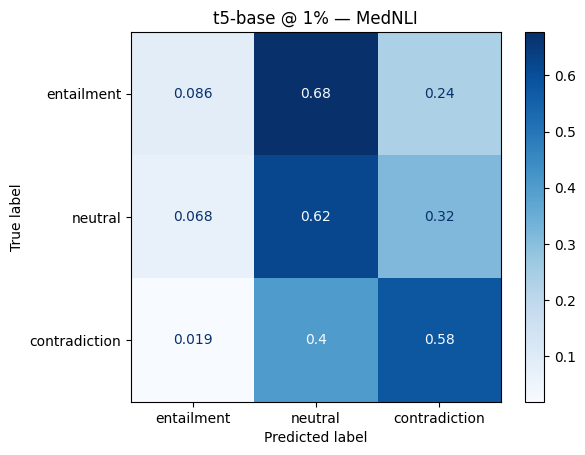

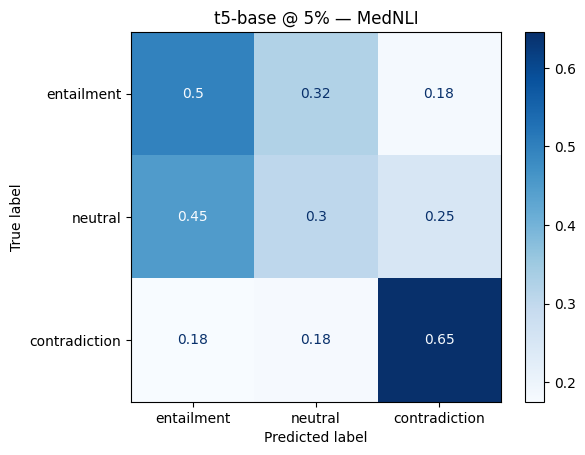

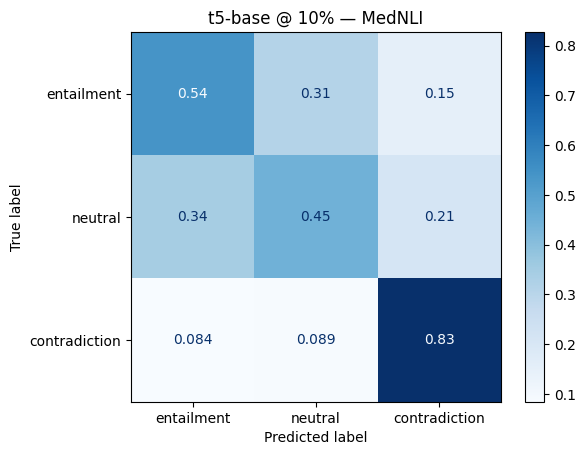

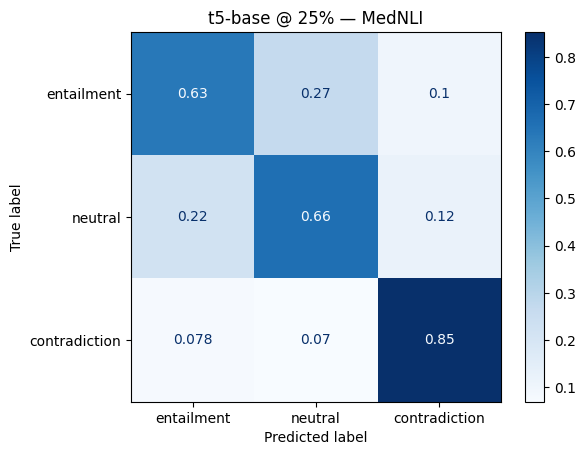

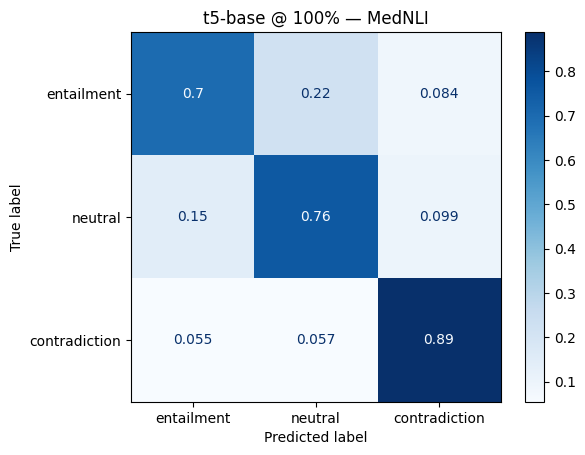

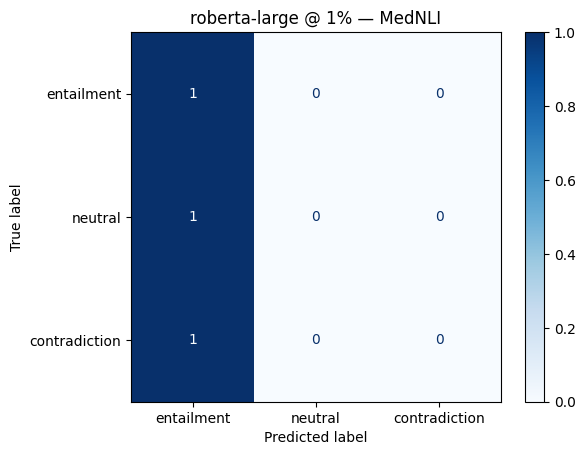

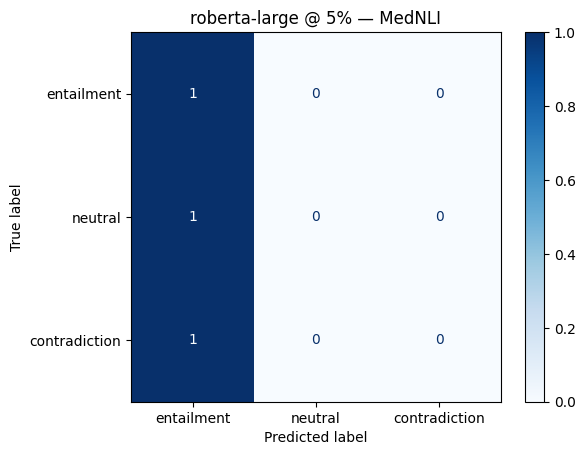

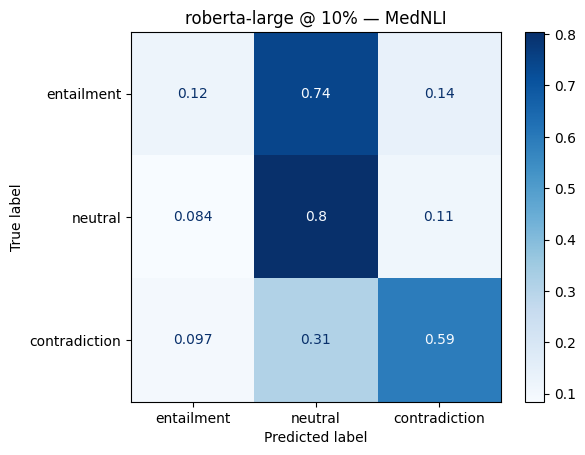

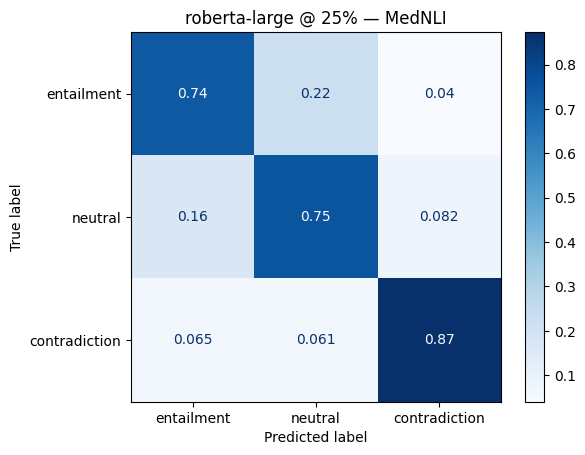

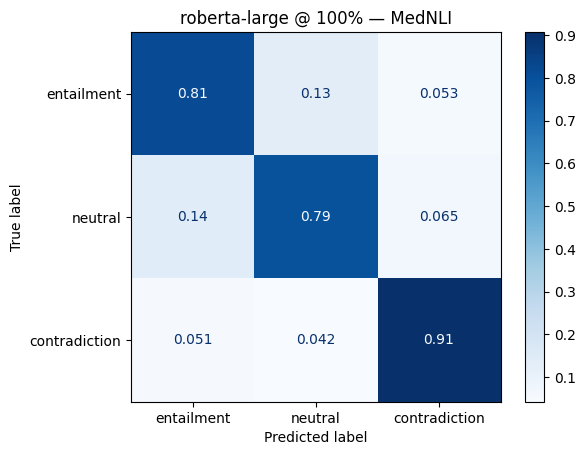

→ skipping BioClinRoBERTa@1% (no preds file)
→ skipping BioClinRoBERTa@5% (no preds file)
→ skipping BioClinRoBERTa@10% (no preds file)
→ skipping BioClinRoBERTa@25% (no preds file)
→ skipping BioClinRoBERTa@100% (no preds file)


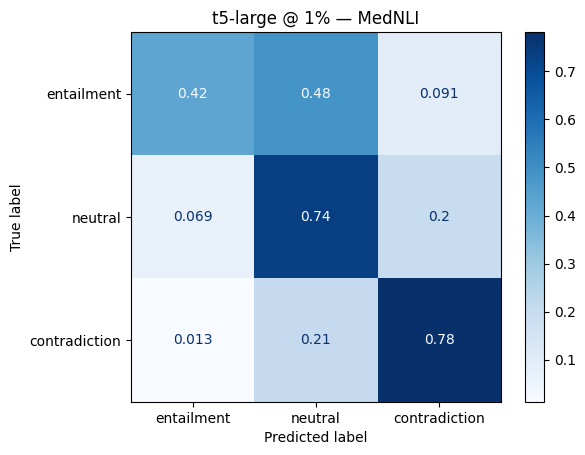

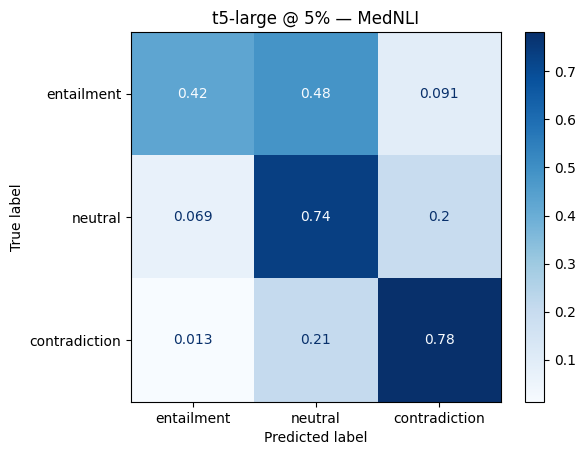

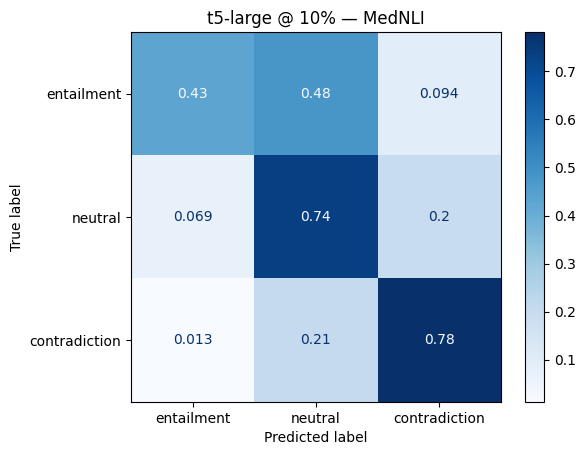

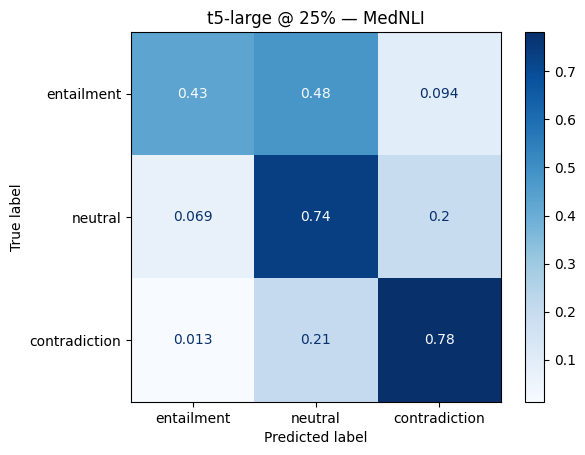

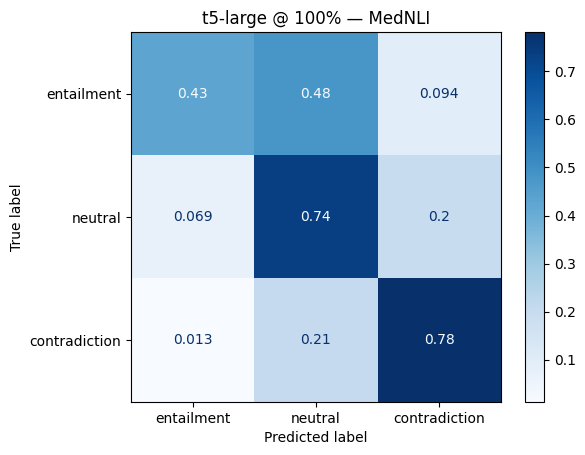

In [ ]:

# Confusion Matrix
def load_preds(model, fraction, split="test"):
    """
    Try to load preds & labels. If the file isn’t there, return (None, None).
    """
    # Sanitize model name so it matches with output dorectory name
    model = model.replace('/', '_')
    fn = os.path.join(
        MODELS_DIR, "finetuned/mednli",
        model, f"{fraction}pct",
        f"{split}_preds_labels.pt"
    )
    if not os.path.exists(fn):
        return None, None

    # allow numpy scalar unpickling
    with torch.serialization.safe_globals([ma.scalar]):
        data = torch.load(fn, weights_only=False)
    return np.array(data["labels"]), np.array(data["preds"])


# now plot confusion matrices, skipping any missing runs
for model in df_finetuned_mednli.model.unique():
    for frac in sorted(df_finetuned_mednli.data_fraction.unique()):
        labels, preds = load_preds(model, frac)
        if labels is None:
            print(f"→ skipping {model}@{frac}% (no preds file)")
            continue

        cm = confusion_matrix(labels, preds, normalize="true", labels=[0, 1, 2])
        disp = ConfusionMatrixDisplay(
            cm,
            display_labels=["entailment", "neutral", "contradiction"]
        )
        disp.plot(cmap="Blues")
        plt.title(f"{model} @ {frac}% — MedNLI")
        plt.show()

# McNemar Test (Optional)

# def mcnemar_test(labels, preds_a, preds_b, exact=False):
#     corr_a = (preds_a == labels)
#     corr_b = (preds_b == labels)
#     b = np.sum( corr_a & ~corr_b )
#     c = np.sum(~corr_a &  corr_b )
#     table = [[0, b],
#              [c, 0]]
#     res = mcnemar(table, exact=exact)
#     return res.statistic, res.pvalue

# fractions = sorted(df_mednli.fraction.unique())
# models    = df_mednli.model.unique()

# for frac in fractions:
#     print(f"\n=== McNemar’s test on MedNLI @ {frac}% ===")
#     for i in range(len(models)):
#         for j in range(i+1, len(models)):
#             m1, m2 = models[i], models[j]
#             lbl1, pred1 = load_preds(m1, frac)
#             lbl2, pred2 = load_preds(m2, frac)

#             if len(lbl1) != len(lbl2):
#                 print(f"  ⚠️  SKIP {m1} vs {m2}: label counts differ ({len(lbl1)} vs {len(lbl2)})")
#                 continue
#             # also sanity-check that the labels themselves are identical
#             if not np.all(lbl1 == lbl2):
#                 print(f"  ⚠️  SKIP {m1} vs {m2}: labels differ")
#                 continue

#             stat, pval = mcnemar_test(lbl1, pred1, pred2, exact=True)
#             print(f"  {m1:25s} vs {m2:25s} → χ²={stat:.1f}, p={pval:.3f}")


# ── Next Steps: ─────────────────────────────────────────────────────────────────
# • RadQA (6.3): load exact_match & f1, compute partial‑match if needed,
#   analyze by question/answer length (you can read lengths from your dataset).
# • CLIP (6.4): load micro_f1 & macro_f1, compute per-class breakdown
#   (you’ll need your test‑set labels & predictions).
# • Cross‑task (6.5): concat all three dfs and plot performance vs. params,
#   data‑fraction curves, etc.

# From here you can build standardized reports (CSV/Excel), run significance tests
# (e.g. McNemar on paired MedNLI predictions), and create your final figures.



## 6.3 RadQA Evaluation

📋 Finetuned RadQA F1 Table:


data_fraction,1,5,10,25,100
model,,,,,
BioClinRoBERTa,0.200,0.107,0.800,0.800,0.800
roberta-large,0.000,0.200,0.100,0.800,0.800
t5-base,0.400,0.400,0.400,0.200,0.800
t5-large,0.457,0.457,nan,nan,nan


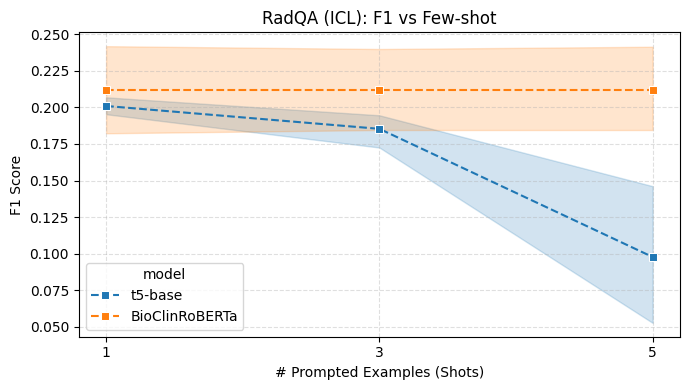

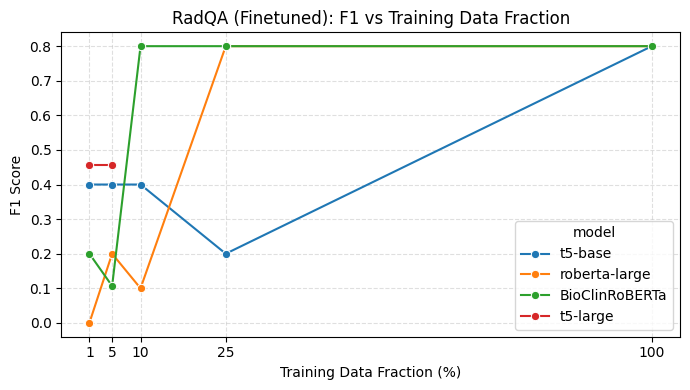

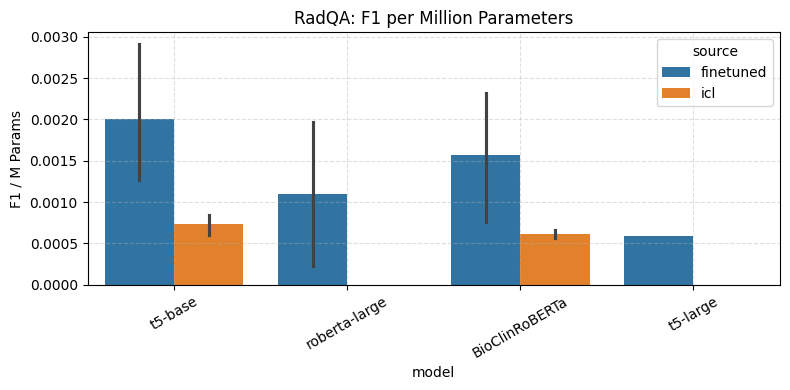

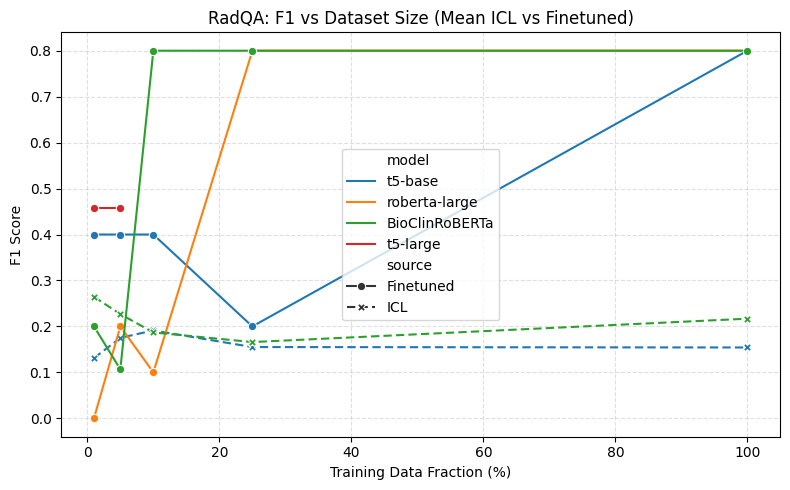

📋 Finetuned RadQA F1 per M Parameter:


data_fraction,1,5,10,25,100
model,,,,,
BioClinRoBERTa,0.001,0.000,0.002,0.002,0.002
roberta-large,0.000,0.001,0.000,0.002,0.002
t5-base,0.002,0.002,0.002,0.001,0.004
t5-large,0.001,0.001,nan,nan,nan


In [ ]:
#───────────────────────────────────────────────────────────────────────────────
# Phase 6.3 – RadQA Evaluation
#───────────────────────────────────────────────────────────────────────────────
import seaborn as sns
import matplotlib.pyplot as plt

# ── 1. Define model sizes ─────────────────────────────────────────────────────
# param_counts = {
#     "roberta-large": 345,
#     "t5-base": 220,
#     "t5-large": 770,
#     # "emilyalsentzer/Bio_ClinicalBERT": 110,
#     "BioClinRoBERTa": 110,
#     "clinical-t5-base": 220,
#     "clinical-t5-large": 770
# }

param_counts = {
    "t5-base": 220,
    "t5-large": 770,
    "roberta-large": 345,
    "clinical-t5-base": 220,
    "clinical-t5-large": 770,
    "emilyalsentzer/Bio_ClinicalBERT": 345,
    "BioClinRoBERTa": 345,
    "google/flan-t5-xl": 1100,
    "google/flan-t5-xxl": 11000,
    "gpt-3": 175000
}

# ── 2. Annotate param counts and efficiency ───────────────────────────────────
df_finetuned_radqa["params_M"] = df_finetuned_radqa["model"].map(param_counts)
df_finetuned_radqa["f1_per_M"] = df_finetuned_radqa["f1"] / df_finetuned_radqa["params_M"]

df_icl_radqa["params_M"] = df_icl_radqa["model"].map(param_counts)
df_icl_radqa["f1_per_M"] = df_icl_radqa["f1"] / df_icl_radqa["params_M"]

# ── 3. Pivot: Finetuned F1 scores by data fraction ────────────────────────────
print("📋 Finetuned RadQA F1 Table:")
display(df_finetuned_radqa.pivot_table(
    index="model", columns="data_fraction", values="f1"
).style.format("{:.3f}"))

# ── 4. Plot: F1 vs Few-shot (ICL) ─────────────────────────────────────────────
plt.figure(figsize=(7, 4))
sns.lineplot(
    data=df_icl_radqa,
    x="num_shots", y="f1",
    hue="model", marker="s",
    linestyle="--"
)
plt.title("RadQA (ICL): F1 vs Few-shot")
plt.xlabel("# Prompted Examples (Shots)")
plt.ylabel("F1 Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.xticks(sorted(df_icl_radqa["num_shots"].unique()))
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/radqa/radqa_icl_f1_vs_shots.png", dpi=300)
plt.show()

# ── 5. Plot: F1 vs Data Fraction (Finetuned) ──────────────────────────────────
plt.figure(figsize=(7, 4))
sns.lineplot(
    data=df_finetuned_radqa,
    x="data_fraction", y="f1",
    hue="model", marker="o"
)
plt.title("RadQA (Finetuned): F1 vs Training Data Fraction")
plt.xlabel("Training Data Fraction (%)")
plt.ylabel("F1 Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.xticks(sorted(df_finetuned_radqa["data_fraction"].unique()))
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/radqa/radqa_finetuned_f1_vs_data_fraction.png", dpi=300)
plt.show()

# ── 6. Plot: F1 Efficiency (F1 per M Params) ──────────────────────────────────
plt.figure(figsize=(8, 4))
sns.barplot(
    data=pd.concat([df_finetuned_radqa.assign(source="finetuned"),
                    df_icl_radqa.assign(source="icl")]),
    x="model", y="f1_per_M", hue="source"
)
plt.title("RadQA: F1 per Million Parameters")
plt.ylabel("F1 / M Params")
plt.xticks(rotation=30)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/radqa/radqa_efficiency_f1_per_M.png", dpi=300)
plt.show()

# ── RADQA Accuracy Plot (F1) ───────────────────────────────────────────────

# 1. Average ICL metrics across few-shots per data_fraction
icl_avg_radqa = (
    df_icl_radqa
    .groupby(["model", "data_fraction"], as_index=False)
    .agg({"f1": "mean"})
)
icl_avg_radqa["source"] = "ICL"

# 2. Finetuned
ft_radqa = df_finetuned_radqa[["model", "data_fraction", "f1"]].copy()
ft_radqa["source"] = "Finetuned"

# 3. Combine
df_plot_radqa = pd.concat([ft_radqa, icl_avg_radqa], ignore_index=True)

# 4. Plot
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_plot_radqa,
    x="data_fraction", y="f1",
    hue="model", style="source",
    dashes={"Finetuned": "", "ICL": (4, 2)},
    markers=True
)
plt.title("RadQA: F1 vs Dataset Size (Mean ICL vs Finetuned)")
plt.xlabel("Training Data Fraction (%)")
plt.ylabel("F1 Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/radqa/radqa_f1_vs_fraction_mean_icl.png", dpi=300)
plt.show()

# ── 7. Summary Table: F1 Efficiency (Finetuned) ───────────────────────────────
print("📋 Finetuned RadQA F1 per M Parameter:")
display(df_finetuned_radqa.pivot_table(
    "f1_per_M", index="model", columns="data_fraction"
).style.format("{:.3f}"))


## 6.4 CLIP Evaluation

📊 CLIP micro_F1 / macro_F1 by model × fraction
                macro_f1                                          micro_f1  \
data_fraction        1         5         10        25        100       1     
model                                                                        
BioClinRoBERTa  0.780842  0.978737  0.978875  0.978875  0.979133  0.766065   
roberta-large   0.000000  0.000000  0.112554  0.196738  0.508914  0.000000   

                                                        
data_fraction        5         10        25        100  
model                                                   
BioClinRoBERTa  0.938626  0.938700  0.938697  0.938822  
roberta-large   0.000000  0.560531  0.652004  0.748522  

📋 Finetuned CLIP Macro-F1 Table:


data_fraction,1,5,10,25,100
model,,,,,
BioClinRoBERTa,0.781,0.979,0.979,0.979,0.979
roberta-large,0.000,0.000,0.113,0.197,0.509


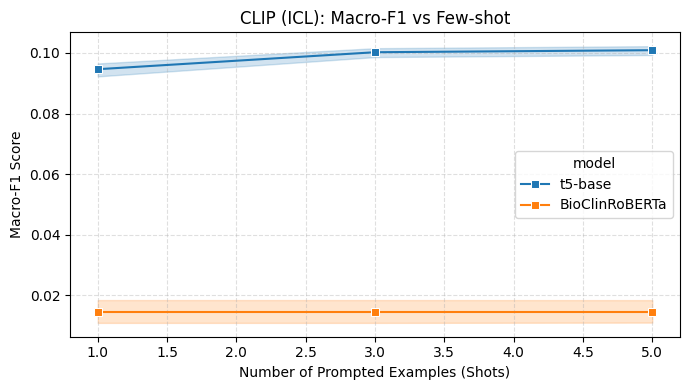

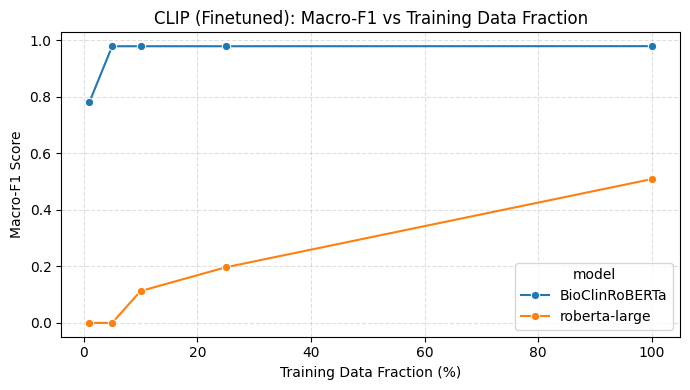

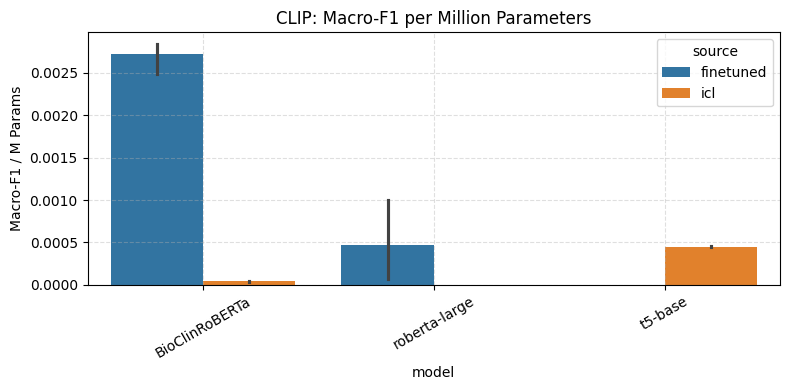

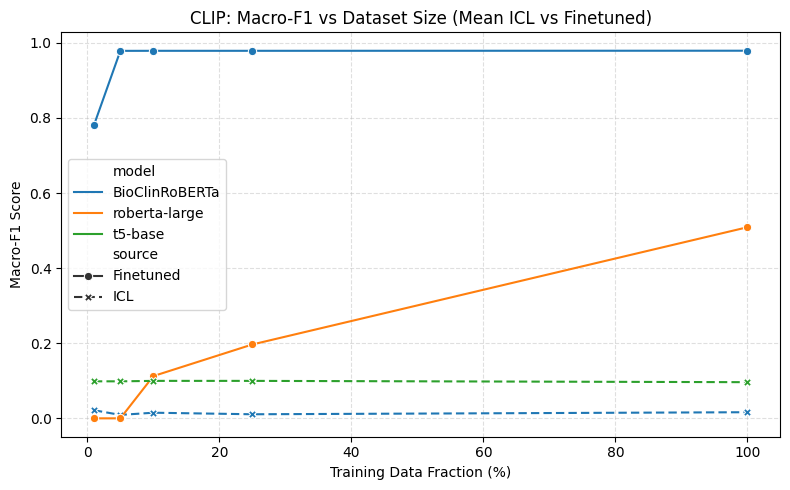

📋 Finetuned CLIP Macro-F1 per M Parameters:


data_fraction,1,5,10,25,100
model,,,,,
BioClinRoBERTa,0.002,0.003,0.003,0.003,0.003
roberta-large,0.000,0.000,0.000,0.001,0.001


In [ ]:

#───────────────────────────────────────────────────────────────────────────────
# Phase 6.4 – CLIP Evaluation
#───────────────────────────────────────────────────────────────────────────────
# ── 2) Pivot table of micro_F1 / macro_F1 ────────────────────────────────────────
print("📊 CLIP micro_F1 / macro_F1 by model × fraction")
pivot = df_finetuned_clip.pivot_table(
    index="model",
    columns="data_fraction",
    values=["micro_f1","macro_f1"]
)
print(pivot)
print()

# ── Create output folder ──────────────────────────────────────────────────────
os.makedirs("clip", exist_ok=True)

# ── Define model sizes (M params) ─────────────────────────────────────────────
# param_counts = {
#     "roberta-large": 345,
#     "t5-base": 220,
#     "t5-large": 770,
#     # "emilyalsentzer/Bio_ClinicalBERT": 110,
#     "BioClinRoBERTa": 345,
#     "clinical-t5-base": 220,
#     "clinical-t5-large": 770
# }

param_counts = {
    "t5-base": 220,
    "t5-large": 770,
    "roberta-large": 345,
    "clinical-t5-base": 220,
    "clinical-t5-large": 770,
    "emilyalsentzer/Bio_ClinicalBERT": 345,
    "BioClinRoBERTa": 345,
    "google/flan-t5-xl": 1100,
    "google/flan-t5-xxl": 11000,
    "gpt-3": 175000
}

df_finetuned_clip["params_M"] = df_finetuned_clip["model"].map(param_counts)
df_finetuned_clip["macro_f1_per_M"] = df_finetuned_clip["macro_f1"] / df_finetuned_clip["params_M"]

df_icl_clip["params_M"] = df_icl_clip["model"].map(param_counts)
df_icl_clip["macro_f1_per_M"] = df_icl_clip["macro_f1"] / df_icl_clip["params_M"]

# ── Pivot Table: Macro-F1 ─────────────────────────────────────────────────────
print("📋 Finetuned CLIP Macro-F1 Table:")
display(df_finetuned_clip.pivot_table(
    index="model", columns="data_fraction", values="macro_f1"
).style.format("{:.3f}"))

# ── 1. Macro-F1 vs Num Shots (ICL) ────────────────────────────────────────────
plt.figure(figsize=(7, 4))
sns.lineplot(
    data=df_icl_clip,
    x="num_shots", y="macro_f1",
    hue="model", marker="s"
)
plt.title("CLIP (ICL): Macro-F1 vs Few-shot")
plt.xlabel("Number of Prompted Examples (Shots)")
plt.ylabel("Macro-F1 Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/clip/clip_icl_macro_f1_vs_shots.png", dpi=300)
plt.show()

# ── 2. Macro-F1 vs Data Fraction (Finetuned) ──────────────────────────────────
plt.figure(figsize=(7, 4))
sns.lineplot(
    data=df_finetuned_clip,
    x="data_fraction", y="macro_f1",
    hue="model", marker="o"
)
plt.title("CLIP (Finetuned): Macro-F1 vs Training Data Fraction")
plt.xlabel("Training Data Fraction (%)")
plt.ylabel("Macro-F1 Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/clip/clip_finetuned_macro_f1_vs_data_fraction.png", dpi=300)
plt.show()

# ── 3. Efficiency Plot: Macro-F1 per M Params ─────────────────────────────────
plt.figure(figsize=(8, 4))
sns.barplot(
    data=pd.concat([df_finetuned_clip.assign(source="finetuned"),
                    df_icl_clip.assign(source="icl")]),
    x="model", y="macro_f1_per_M", hue="source"
)
plt.title("CLIP: Macro-F1 per Million Parameters")
plt.ylabel("Macro-F1 / M Params")
plt.xticks(rotation=30)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/clip/clip_efficiency_macro_f1_per_M.png", dpi=300)
plt.show()

# ── CLIP Accuracy Plot (Macro-F1) ───────────────────────────────────────────

# 1. Average ICL metrics across few-shots per data_fraction
icl_avg_clip = (
    df_icl_clip
    .groupby(["model", "data_fraction"], as_index=False)
    .agg({"macro_f1": "mean"})
)
icl_avg_clip["source"] = "ICL"

# 2. Finetuned
ft_clip = df_finetuned_clip[["model", "data_fraction", "macro_f1"]].copy()
ft_clip["source"] = "Finetuned"

# 3. Combine
df_plot_clip = pd.concat([ft_clip, icl_avg_clip], ignore_index=True)

# 4. Plot
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_plot_clip,
    x="data_fraction", y="macro_f1",
    hue="model", style="source",
    dashes={"Finetuned": "", "ICL": (4, 2)},
    markers=True
)
plt.title("CLIP: Macro-F1 vs Dataset Size (Mean ICL vs Finetuned)")
plt.xlabel("Training Data Fraction (%)")
plt.ylabel("Macro-F1 Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/clip/clip_macro_f1_vs_fraction_mean_icl.png", dpi=300)
plt.show()

# ── 4. Table: Macro-F1 per M Parameter (Finetuned) ───────────────────────────
print("📋 Finetuned CLIP Macro-F1 per M Parameters:")
display(df_finetuned_clip.pivot_table(
    index="model",
    columns="data_fraction",
    values="macro_f1_per_M"
).style.format("{:.3f}"))


### 📊 Cross-task Cross-model Finetuned vs ICL - Accuracy Comparison

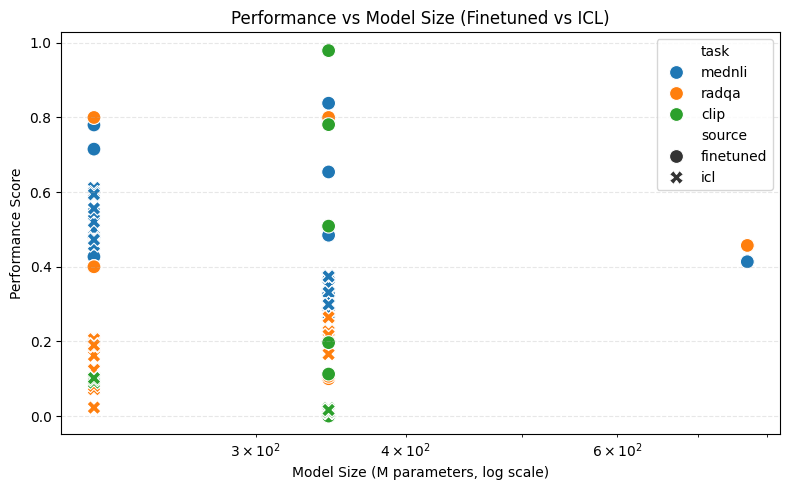

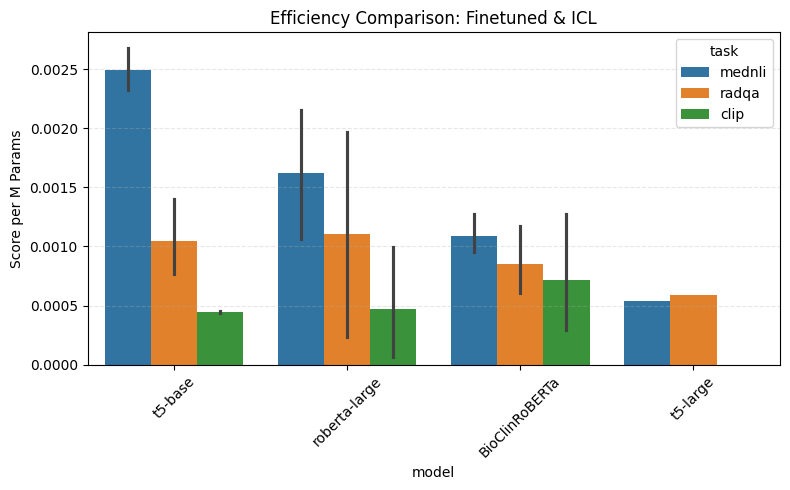

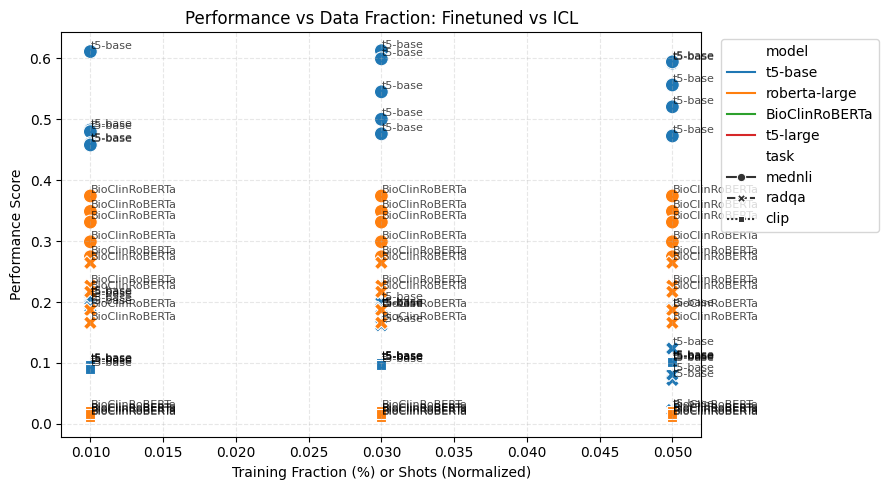

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────────────────────────────────────────────────────────────────────
# 1. Normalize shot → data_fraction for ICL
shot_to_fraction = {1: 0.01, 3: 0.03, 5: 0.05}

for df_icl in [df_icl_mednli, df_icl_radqa, df_icl_clip]:
    df_icl["fraction"] = df_icl["num_shots"].map(shot_to_fraction)
    df_icl["source"] = "icl"

# ─────────────────────────────────────────────────────────────────────────────
# 2. Combine per-task + metric + labeling
df_mednli_all = pd.concat([df_finetuned_mednli, df_icl_mednli], ignore_index=True)
df_mednli_all["task"] = "mednli"
df_mednli_all["score"] = df_mednli_all["accuracy"]

df_radqa_all = pd.concat([df_finetuned_radqa, df_icl_radqa], ignore_index=True)
df_radqa_all["task"] = "radqa"
df_radqa_all["score"] = df_radqa_all["f1"]

df_clip_all = pd.concat([df_finetuned_clip, df_icl_clip], ignore_index=True)
df_clip_all["task"] = "clip"
df_clip_all["score"] = df_clip_all["macro_f1"]

# ─────────────────────────────────────────────────────────────────────────────
# 3. Parameter counts and efficiency
param_counts = {
    "t5-base": 220,
    "clinical-t5-base": 220,
    "t5-large": 770,
    "clinical-t5-large": 770,
    "roberta-large": 345,
    # "emilyalsentzer/Bio_ClinicalBERT": 345,
    "BioClinRoBERTa": 345,
    "google/flan-t5-xl": 1100,
    "google/flan-t5-xxl": 11000,
    "gpt-3": 175000
}

for df in [df_mednli_all, df_radqa_all, df_clip_all]:
    df["params_M"] = df["model"].map(param_counts)
    df["efficiency"] = df["score"] / df["params_M"]

# ─────────────────────────────────────────────────────────────────────────────
# 4. Merge all
df_all = pd.concat([
    df_mednli_all[["task", "model", "source", "fraction", "score", "params_M", "efficiency"]],
    df_radqa_all[["task", "model", "source", "fraction", "score", "params_M", "efficiency"]],
    df_clip_all[["task", "model", "source", "fraction", "score", "params_M", "efficiency"]],
], ignore_index=True)

# Optional: save dir
os.makedirs(RESULTS_DIR + "/evaluation", exist_ok=True)

# ─────────────────────────────────────────────────────────────────────────────
# 5. Plot: Score vs Param Count
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_all, x="params_M", y="score", hue="task", style="source", s=100)
plt.xscale("log")
plt.xlabel("Model Size (M parameters, log scale)")
plt.ylabel("Performance Score")
plt.title("Performance vs Model Size (Finetuned vs ICL)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/evaluation/perf_vs_params.png", dpi=300)
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 6. Plot: Efficiency Score / Param
plt.figure(figsize=(8, 5))
sns.barplot(data=df_all, x="model", y="efficiency", hue="task")
plt.xticks(rotation=45)
plt.ylabel("Score per M Params")
plt.title("Efficiency Comparison: Finetuned & ICL")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/evaluation/efficiency_score_per_param.png", dpi=300)
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 7. Score vs Data Fraction (plus ICL lines)
plt.figure(figsize=(9, 5))
sns.lineplot(
    data=df_all[df_all["source"] == "finetuned"],
    x="fraction", y="score", hue="model", style="task", markers=True, dashes=True
)

# Overlay ICL points (use scatter for clarity)
icl_df = df_all[df_all["source"] == "icl"]
sns.scatterplot(
    data=icl_df,
    x="fraction", y="score",
    hue="model", style="task", marker="X", s=100, legend=False
)

# Annotate
for _, row in icl_df.iterrows():
    plt.text(row["fraction"], row["score"] + 0.005, f"{row['model']}", fontsize=8, alpha=0.7)

plt.title("Performance vs Data Fraction: Finetuned vs ICL")
plt.xlabel("Training Fraction (%) or Shots (Normalized)")
plt.ylabel("Performance Score")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/evaluation/score_vs_fraction_finetuned_vs_icl.png", dpi=300)
plt.show()


## 6.5.1 Performance comparison for Few-shots (ICL) vs Finetuned across all three tasks

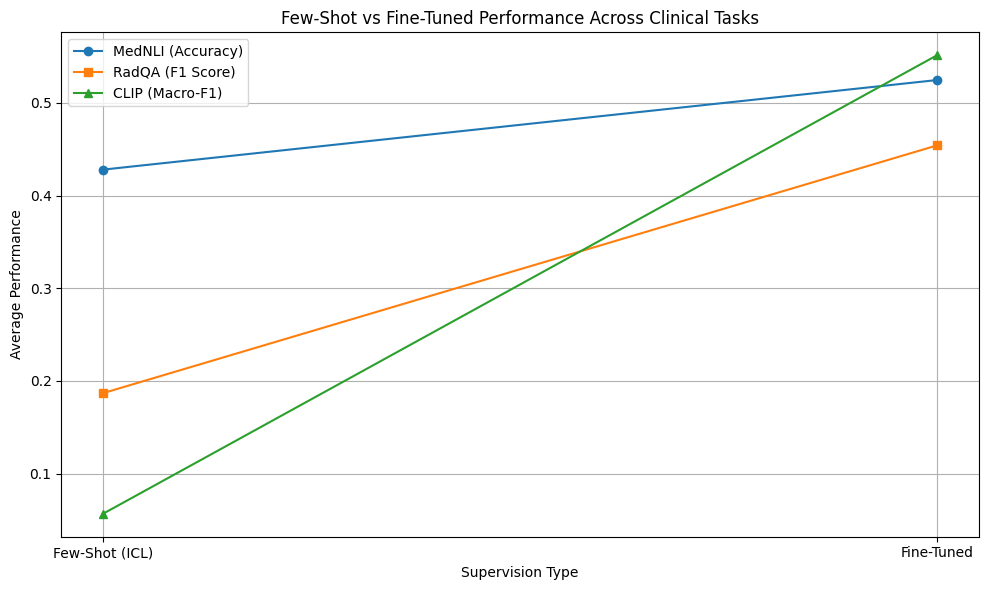

In [ ]:
import matplotlib.pyplot as plt

# Compute average scores for each task
icl_avg_mednli = df_icl_mednli[df_icl_mednli["num_shots"] > 0]["accuracy"].mean()
ft_avg_mednli = df_finetuned_mednli["accuracy"].mean()

icl_avg_radqa = df_icl_radqa[df_icl_radqa["num_shots"] > 0]["f1"].mean()
ft_avg_radqa = df_finetuned_radqa["f1"].mean()

icl_avg_clip = df_icl_clip[df_icl_clip["num_shots"] > 0]["macro_f1"].mean()
ft_avg_clip = df_finetuned_clip["macro_f1"].mean()

# X-axis: Few-shot vs Fine-tuned
methods = ["Few-Shot (ICL)", "Fine-Tuned"]
x = range(len(methods))

# Y-axis values for each task
mednli_scores = [icl_avg_mednli, ft_avg_mednli]
radqa_scores = [icl_avg_radqa, ft_avg_radqa]
clip_scores = [icl_avg_clip, ft_avg_clip]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, mednli_scores, marker='o', label='MedNLI (Accuracy)')
plt.plot(x, radqa_scores, marker='s', label='RadQA (F1 Score)')
plt.plot(x, clip_scores, marker='^', label='CLIP (Macro-F1)')

plt.xticks(x, methods)
plt.xlabel('Supervision Type')
plt.ylabel('Average Performance')
plt.title('Few-Shot vs Fine-Tuned Performance Across Clinical Tasks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(RESULTS_DIR + "/evaluation/few_shot_vs_fine_tuned_performance.png", dpi=300)
plt.show()



## 6.5.2 Cross-task cross-model tabular comparison with FLOPS TFLOPS and Efficiency

In [ ]:
# 6.5.2 Cross-task cross-model tabular comparison with FLOPS TFLOPS and Efficiency

# ─────────────────────────────────────────────────────────────────────────────
# Load parameter counts
param_counts = {
    "t5-base": 220,
    "t5-large": 770,
    "roberta-large": 345,
    "clinical-t5-base": 220,
    "clinical-t5-large": 770,
    "emilyalsentzer/Bio_ClinicalBERT": 345,
    "BioClinRoBERTa": 345,
    "google/flan-t5-xl": 1100,
    "google/flan-t5-xxl": 11000,
    "gpt-3": 175000
}

# Full training example counts (full = 100% training)
training_examples = {
    "mednli": 11232,
    "radqa": 4878,
    "clip": 76654
}

# Assume 5 epochs (as per your config)
epochs = 5

# ─────────────────────────────────────────────────────────────────────────────
# Step 1: Aggregate best scores per model & source
best_mednli = df_mednli_all.groupby(["model", "source"])["accuracy"].max().reset_index()
best_radqa  = df_radqa_all.groupby(["model", "source"])["f1"].max().reset_index()
best_clip   = df_clip_all.groupby(["model", "source"])["macro_f1"].max().reset_index()

# Step 2: Merge results
df_scores = best_mednli.merge(best_radqa, on=["model", "source"], how="outer")
df_scores = df_scores.merge(best_clip, on=["model", "source"], how="outer")

# Step 3: Model type tagging
def categorize_model(name):
    name = name.lower()
    if "clinical" in name or "bioclin" in name or "emilyalsentzer" in name:
        return "Clinical"
    elif "flan" in name or "gpt" in name:
        return "ICL"
    else:
        return "General"

df_scores["model_type"] = df_scores["model"].apply(categorize_model)

# Step 4: FLOPs estimation (6×FLOPs per token, per sample × param count × epochs)
df_scores["params_M"] = df_scores["model"].map(param_counts)

df_scores["mednli_flops"] = df_scores["params_M"] * 1e6 * training_examples["mednli"] * 6 * epochs / 1e12
df_scores["radqa_flops"]  = df_scores["params_M"] * 1e6 * training_examples["radqa"]  * 6 * epochs / 1e12
df_scores["clip_flops"]   = df_scores["params_M"] * 1e6 * training_examples["clip"]   * 6 * epochs / 1e12

# Step 5: Efficiency
df_scores["mednli_efficiency"] = df_scores["accuracy"]       / df_scores["mednli_flops"]
df_scores["radqa_efficiency"]  = df_scores["f1"]             / df_scores["radqa_flops"]
df_scores["clip_efficiency"]   = df_scores["macro_f1"]       / df_scores["clip_flops"]

# Step 6: Rename columns first (ensure they're available)
df_scores = df_scores.rename(columns={
    "accuracy": "mednli_acc",
    "f1": "radqa_f1",
    "macro_f1": "clip_macro_f1"
})


# Step 7: Round and clean for export
final_table = df_scores[[
    "model", "model_type", "source", "params_M",
    "mednli_acc", "radqa_f1", "clip_macro_f1",
    "mednli_flops", "radqa_flops", "clip_flops",
    "mednli_efficiency", "radqa_efficiency", "clip_efficiency"
]].copy()


# Round values
final_table[["mednli_acc", "radqa_f1", "clip_macro_f1"]] = final_table[
    ["mednli_acc", "radqa_f1", "clip_macro_f1"]
].round(3)

final_table[["mednli_flops", "radqa_flops", "clip_flops"]] = final_table[
    ["mednli_flops", "radqa_flops", "clip_flops"]
].round(2)

final_table[["mednli_efficiency", "radqa_efficiency", "clip_efficiency"]] = final_table[
    ["mednli_efficiency", "radqa_efficiency", "clip_efficiency"]
].round(4)

# Step 8: Sort and save
final_table = final_table.sort_values(by="params_M").reset_index(drop=True)

# Save final table
out_path = os.path.join(RESULTS_DIR, "evaluation", "summary_with_flops_and_efficiency.csv")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
final_table.to_csv(out_path, index=False)

# Optional: display
print("📊 Final Summary Table (Table 3 Style):")
display(final_table)


📊 Final Summary Table (Table 3 Style):


,model,model_type,source,params_M,mednli_acc,radqa_f1,clip_macro_f1,mednli_flops,radqa_flops,clip_flops,mednli_efficiency,radqa_efficiency,clip_efficiency
0,t5-base,General,finetuned,220,0.780,0.800,NaN,74.13,32.19,505.92,0.0105,0.0248,NaN
1,t5-base,General,icl,220,0.613,0.209,0.103,74.13,32.19,505.92,0.0083,0.0065,0.0002
2,BioClinRoBERTa,Clinical,icl,345,0.374,0.264,0.022,116.25,50.49,793.37,0.0032,0.0052,0.0000
3,BioClinRoBERTa,Clinical,finetuned,345,0.793,0.800,0.979,116.25,50.49,793.37,0.0068,0.0158,0.0012
4,roberta-large,General,finetuned,345,0.838,0.800,0.509,116.25,50.49,793.37,0.0072,0.0158,0.0006
5,t5-large,General,finetuned,770,0.414,0.457,NaN,259.46,112.68,1770.71,0.0016,0.0041,NaN


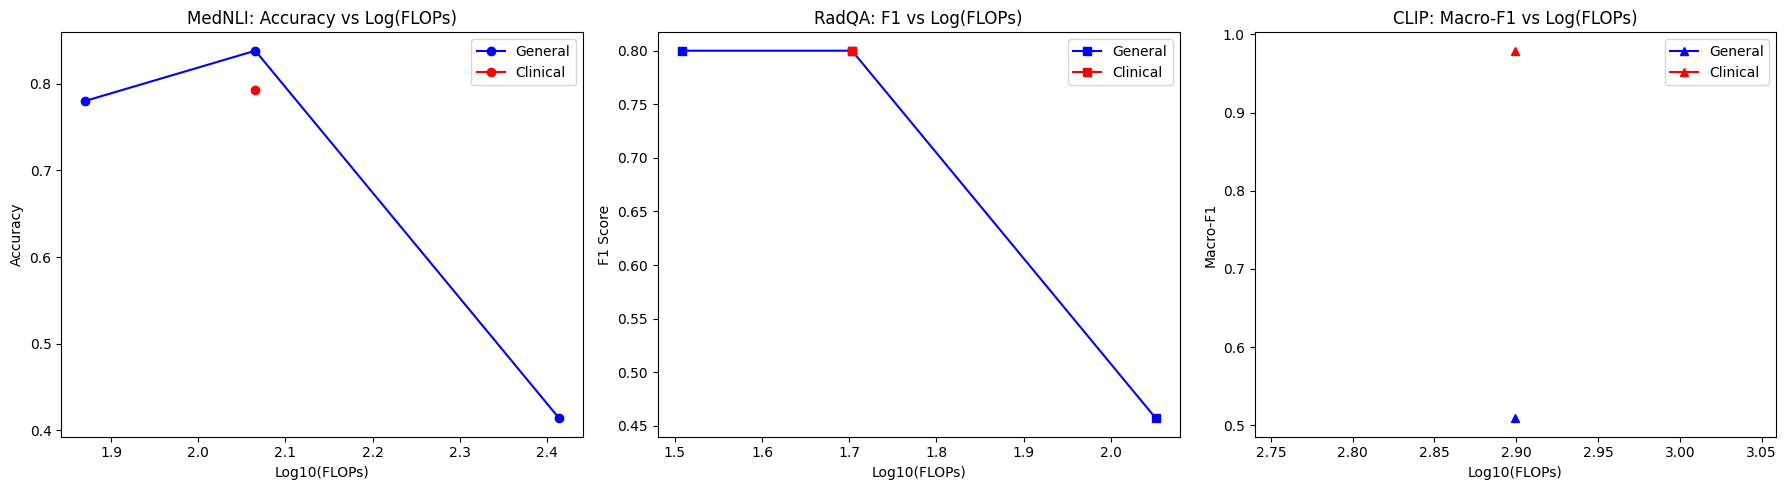

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter only fine-tuned models
df_finetuned = final_table[final_table["source"] == "finetuned"].copy()

# Compute log10 FLOPs
df_finetuned["log_mednli_flops"] = np.log10(df_finetuned["mednli_flops"])
df_finetuned["log_radqa_flops"] = np.log10(df_finetuned["radqa_flops"])
df_finetuned["log_clip_flops"] = np.log10(df_finetuned["clip_flops"])

# Color coding by model type
color_map = {"Clinical": "red", "General": "blue"}

# Plot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MedNLI
for mtype in df_finetuned["model_type"].unique():
    data = df_finetuned[df_finetuned["model_type"] == mtype]
    axes[0].plot(data["log_mednli_flops"], data["mednli_acc"], marker='o', label=mtype, color=color_map[mtype])
axes[0].set_title("MedNLI: Accuracy vs Log(FLOPs)")
axes[0].set_xlabel("Log10(FLOPs)")
axes[0].set_ylabel("Accuracy")

# RadQA
for mtype in df_finetuned["model_type"].unique():
    data = df_finetuned[df_finetuned["model_type"] == mtype]
    axes[1].plot(data["log_radqa_flops"], data["radqa_f1"], marker='s', label=mtype, color=color_map[mtype])
axes[1].set_title("RadQA: F1 vs Log(FLOPs)")
axes[1].set_xlabel("Log10(FLOPs)")
axes[1].set_ylabel("F1 Score")

# CLIP
for mtype in df_finetuned["model_type"].unique():
    data = df_finetuned[df_finetuned["model_type"] == mtype]
    axes[2].plot(data["log_clip_flops"], data["clip_macro_f1"], marker='^', label=mtype, color=color_map[mtype])
axes[2].set_title("CLIP: Macro-F1 vs Log(FLOPs)")
axes[2].set_xlabel("Log10(FLOPs)")
axes[2].set_ylabel("Macro-F1")

# Add legend
for ax in axes:
    ax.legend()
plt.tight_layout()
plt.show()
